# Mnist usando CNN

In [19]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


## Variáveis

In [20]:
test_size = 0.2
random_state = 42
patience = 5

## Preparação e separação dos dados

In [21]:
mnist = datasets.fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"]

X = X.astype(np.float32)
y = y.astype(np.int64)

X = X / 255.0

X = X.reshape(-1, 28, 28, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((56000, 28, 28, 1), (56000,), (14000, 28, 28, 1), (14000,))

## Construção do Modelo

In [22]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1600)             

## Tensorflow usando GPU para treino

In [23]:
#tf.debugging.set_log_device_placement(True)
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12812300679267084199
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5653921792
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9998582120956045731
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 5050, pci bus id: 0000:01:00.0, compute capability: 12.0"
 xla_global_id: 416903419]

## Treinamento

In [24]:
es_loss_val = keras.callbacks.EarlyStopping(monitor='val_loss',mode = min, patience=patience, restore_best_weights=True)
es_val = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = max, patience=patience, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10*patience, batch_size=32, validation_data=(X_test, y_test),verbose = 1 ,callbacks=[es_loss_val, es_val])

Epoch 1/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2158 - accuracy: 0.9348 - val_loss: 0.0555 - val_accuracy: 0.9824
Epoch 2/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0824 - accuracy: 0.9748 - val_loss: 0.0504 - val_accuracy: 0.9853
Epoch 3/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0650 - accuracy: 0.9807 - val_loss: 0.0396 - val_accuracy: 0.9878
Epoch 4/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0538 - accuracy: 0.9837 - val_loss: 0.0324 - val_accuracy: 0.9904
Epoch 5/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0473 - accuracy: 0.9857 - val_loss: 0.0325 - val_accuracy: 0.9906
Epoch 6/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0415 - accuracy: 0.9867 - val_loss: 0.0317 - val_accuracy: 0.9901
Epoch 7/50
1750/1750 [==============================] - 5s 3ms/step - loss: 0.0379 - accuracy: 0.9883 - val_loss: 0.0285 - val_accuracy:

In [25]:
#model.save("C:\\Users\\rodri\\Desktop\\projetoIa\\model")

## Gráfico de loss

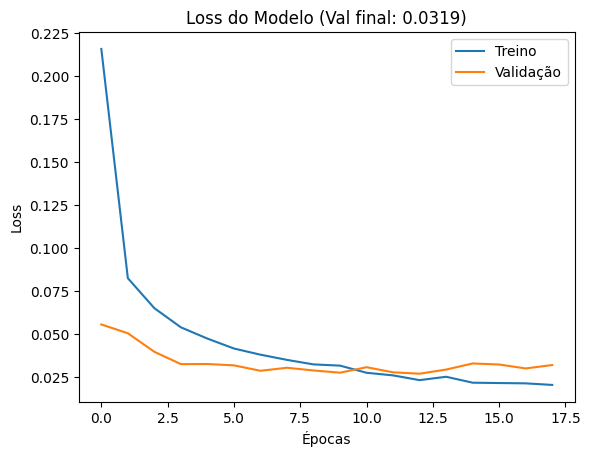

In [26]:
final_val_loss = history.history['val_loss'][-1]

plt.figure()
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title(f'Loss do Modelo (Val final: {final_val_loss:.4f})')
plt.legend()
plt.show()

## Gráfico de accuracy

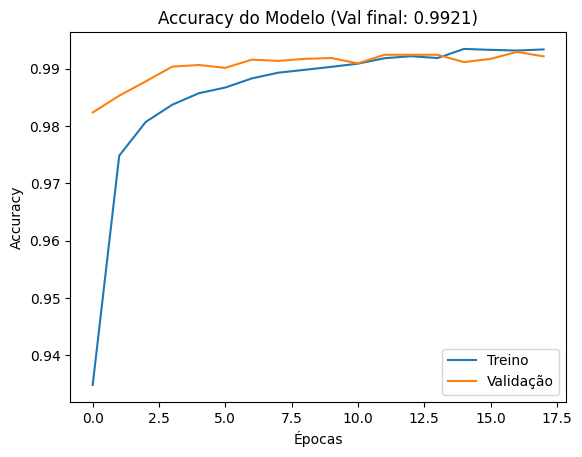

In [27]:
final_val_acc = history.history['val_accuracy'][-1]

plt.figure()
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title(f'Accuracy do Modelo (Val final: {final_val_acc:.4f})')
plt.legend()
plt.show()

## Matriz de confusão

438/438 [==============================] - 0s 958us/step


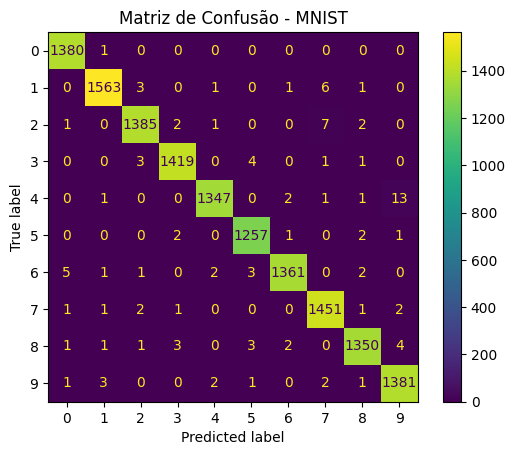

In [28]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)

labels = list(range(10))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)
disp.plot()
plt.title("Matriz de Confusão - MNIST")
plt.show()